In [ ]:
##用scGPT进行细胞亚群预测

In [ ]:
##导入scGPT以及依赖的库
##代码参考github上scGPT的示例代码 Zero-shot Reference Mapping

In [2]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys


import scgpt as scg

# extra dependency for similarity search
try:
    import faiss

    faiss_imported = True
except ImportError:
    faiss_imported = False
    print(
        "faiss not installed! We highly recommend installing it for fast similarity search."
    )
    print("To install it, see https://github.com/facebookresearch/faiss/wiki/Installing-Faiss")

# 忽略一些无关紧要的警告，并不影响程序运行.
warnings.filterwarnings("ignore", category=ResourceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
##将从 Cellxgene上下载的数据分成两部分，一部分用于训练，一部分用于测试，即测试集和训练集
## Cellxgene上下载的公开数据为 A molecular single-cell lung atlas of lethal COVID-19
##数据集网址 https://cellxgene.cziscience.com/collections/e4c9ed14-e560-4900-a3bf-b0f8d2ce6a10

In [3]:
# 读取 h5ad数据
adata = sc.read('lung_atlas_of_lethal_COVID-19.h5ad')

# 设置随机种子确保可重复性
np.random.seed(42)

# 获取细胞总数
n_cells = adata.shape[0]

# 设置测试集比例
test_ratio = 0.2  # 20%测试集
train_ratio = 0.8  # 80%训练集

# 生成随机索引
indices = np.arange(n_cells)
np.random.shuffle(indices)

# 计算分割点
split_idx = int(n_cells * train_ratio)

# 分割索引
train_idx = indices[:split_idx]
test_idx = indices[split_idx:]

# 创建子集
adata_train = adata[train_idx, :].copy()
adata_test = adata[test_idx, :].copy()

print(f"总细胞数: {n_cells}")
print(f"训练集: {len(train_idx)} 细胞 ({train_ratio*100}%)")
print(f"测试集: {len(test_idx)} 细胞 ({test_ratio*100}%)")

总细胞数: 116313
训练集: 93050 细胞 (80.0%)
测试集: 23263 细胞 (20.0%)


In [ ]:
##加载数据。其中训练模型选择了官方推荐的在 3300万正常人类细胞上训练的 whole-human模型，见 https://pypi.org/project/scgpt/0.2.0/

In [4]:
model_dir = Path("./save/scGPT_human")
adata = adata_train
test_adata = adata_test


In [ ]:
##不同地方下载的数据集中，关于基因列名可能不同，通过以下代码得到所下载数据集中的列，由于feature_name常用与命名基因列名，得到数据集中的 gene_col类型。
##同时也可得到cell_type_key对应的值应为多少

In [5]:
print("adata.var 的列名：", adata.var.columns.tolist())
print("adata.var 的前几行：", adata.var.head())


adata.var 的列名： ['feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type']
adata.var 的前几行：                  feature_is_filtered     feature_name feature_reference  \
ENSG00000241860                False  ENSG00000241860    NCBITaxon:9606   
ENSG00000241599                False  ENSG00000241599    NCBITaxon:9606   
ENSG00000229905                False  ENSG00000229905    NCBITaxon:9606   
ENSG00000237491                False        LINC01409    NCBITaxon:9606   
ENSG00000177757                False           FAM87B    NCBITaxon:9606   

                feature_biotype feature_length feature_type  
ENSG00000241860            gene            861       lncRNA  
ENSG00000241599            gene            457       lncRNA  
ENSG00000229905            gene            456       lncRNA  
ENSG00000237491            gene           1089       lncRNA  
ENSG00000177757            gene           1960       lncRNA  


In [ ]:
##依据上面得到的队列名称，将gene_col进行赋值，便于后续使用

In [6]:
gene_col = "feature_name"

In [ ]:
##嵌入训练数据集

In [7]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 22916/33523 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 1454/1454 [09:21<00:00,  2.59it/s]


In [ ]:
##嵌入测试数据集

In [8]:
test_embed_adata = scg.tasks.embed_data(
    test_adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

scGPT - INFO - match 22916/33523 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 364/364 [02:06<00:00,  2.89it/s]


In [ ]:
##标记训练单元格和测试单元格，并遮盖测试单元格上的单元格类型

In [9]:
# concatenate the two datasets
adata_concat = test_embed_adata.concatenate(ref_embed_adata, batch_key="dataset")
print("adata_concat.obs 的列名:")
print(adata_concat.obs.columns.tolist())

adata_concat.obs 的列名:
['biosample_id', 'donor_id', 'cell_type_main', 'cell_type_intermediate', 'cell_type_fine', 'initial_clustering', 'age', 'recorded_race', 'recorded_ethnicity', 'intubation_days', 'interval_death_symptoms_onset_days', 'pmi_h', 'suspension_type', 'assay_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'dataset']


In [10]:
#依据上面输出的队列，对cell_type_key进行赋值，便于后续使用
cell_type_key = "cell_type"
# mark the reference vs. query dataset
adata_concat.obs["is_ref"] = ["Query"] * len(test_embed_adata) + ["Reference"] * len(
    ref_embed_adata
)
adata_concat.obs["is_ref"] = adata_concat.obs["is_ref"].astype("category")
# mask the query dataset cell types
adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].astype("category")
if 'To be predicted' not in adata_concat.obs[cell_type_key].cat.categories:
    adata_concat.obs[cell_type_key] = adata_concat.obs[cell_type_key].cat.add_categories(["To be predicted"])

adata_concat.obs[cell_type_key][: len(test_embed_adata)] = "To be predicted"

In [ ]:
##将嵌入图形化显示出来 （UMAP）
##将训练集和测试集都用 UMAP显示出来，观察和确保嵌入的质量高（同类型细胞在 UMAP图中位置靠近）

2025-12-26 12:01:49.160632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


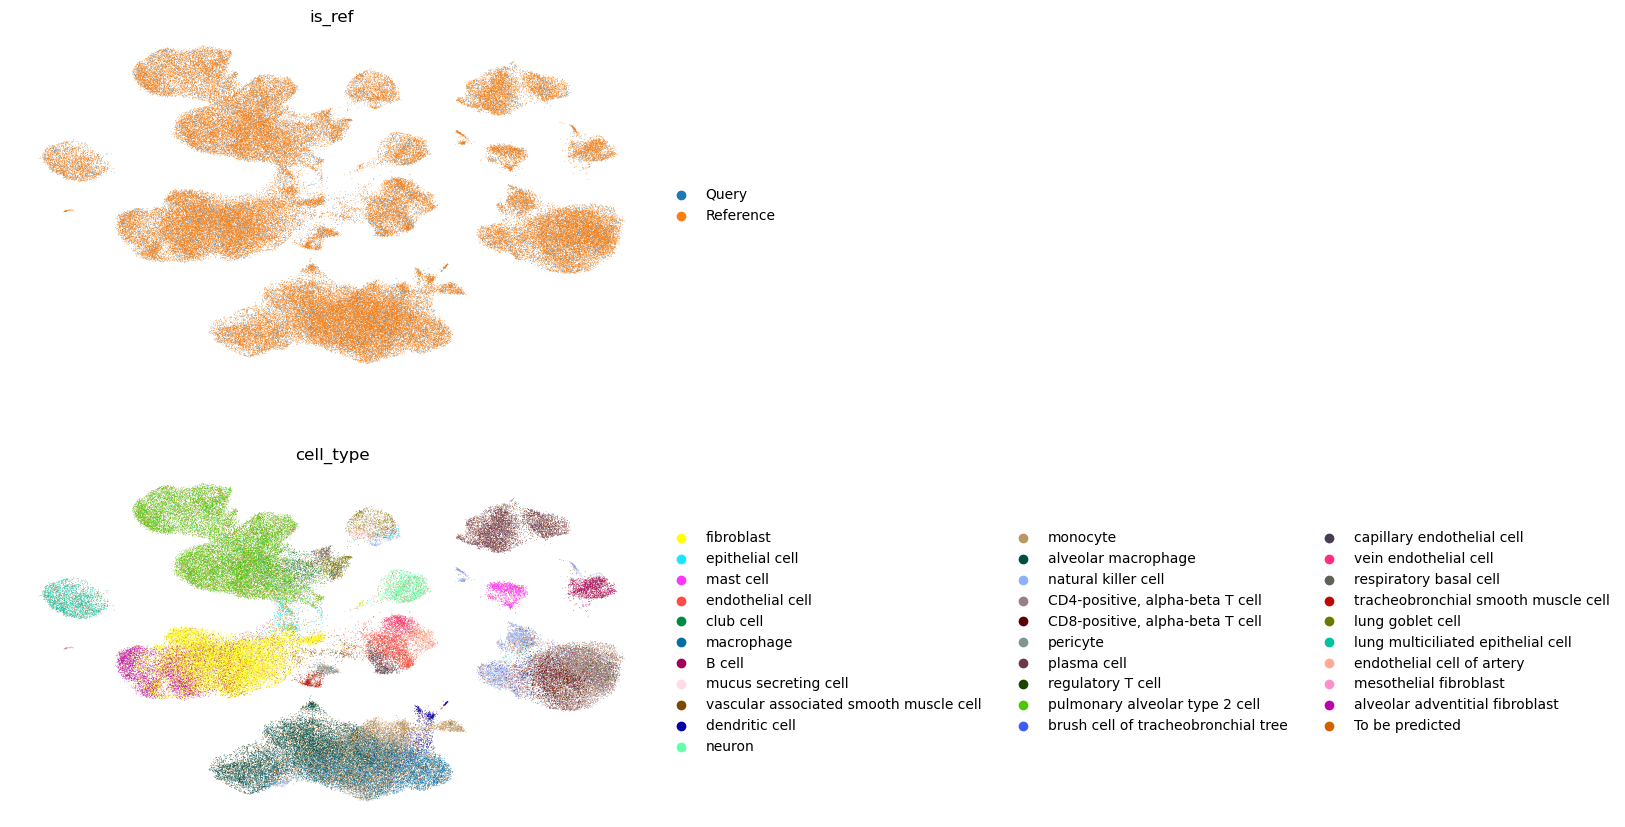

In [11]:
sc.pp.neighbors(adata_concat, use_rep="X_scGPT")
sc.tl.umap(adata_concat)
sc.pl.umap(
    adata_concat, color=["is_ref", cell_type_key], wspace=0.4, frameon=False, ncols=1
)

In [ ]:
##运用scGPT对测试集的数据进行预测

In [12]:
ref_cell_embeddings = ref_embed_adata.obsm["X_scGPT"] # 参考细胞的嵌入向量
test_emebd = test_embed_adata.obsm["X_scGPT"]   # 测试细胞的嵌入向量

k = 10  # 设置k=10个最近邻（可改变而提升性能）


index = faiss.IndexFlatL2(ref_cell_embeddings.shape[1])
index.add(ref_cell_embeddings)

# 为每个测试细胞在参考集中找到 k=10个最近邻
distances, labels = index.search(test_emebd, k)

idx_list=[i for i in range(test_emebd.shape[0])]
preds = []
sim_list = distances
for k in idx_list:   # 遍历每个测试细胞
    if faiss_imported:
        idx = labels[k]
    else:
        idx, sim = get_similar_vectors(test_emebd[k][np.newaxis, ...], ref_cell_embeddings, k)
    pred = ref_embed_adata.obs[cell_type_key][idx].value_counts()
    preds.append(pred.index[0])
gt = test_adata.obs[cell_type_key].to_numpy()  #获取真实细胞类型，用于后续性能评估

In [ ]:
##评估模型的性能

In [13]:
res_dict = {
    "accuracy": accuracy_score(gt, preds),
    "precision": precision_score(gt, preds, average="macro"),
    "recall": recall_score(gt, preds, average="macro"),
    "macro_f1": f1_score(gt, preds, average="macro"),
}

res_dict

{'accuracy': 0.8402613592399948,
 'precision': 0.8038002960137293,
 'recall': 0.7199178104820686,
 'macro_f1': 0.7496635496982211}

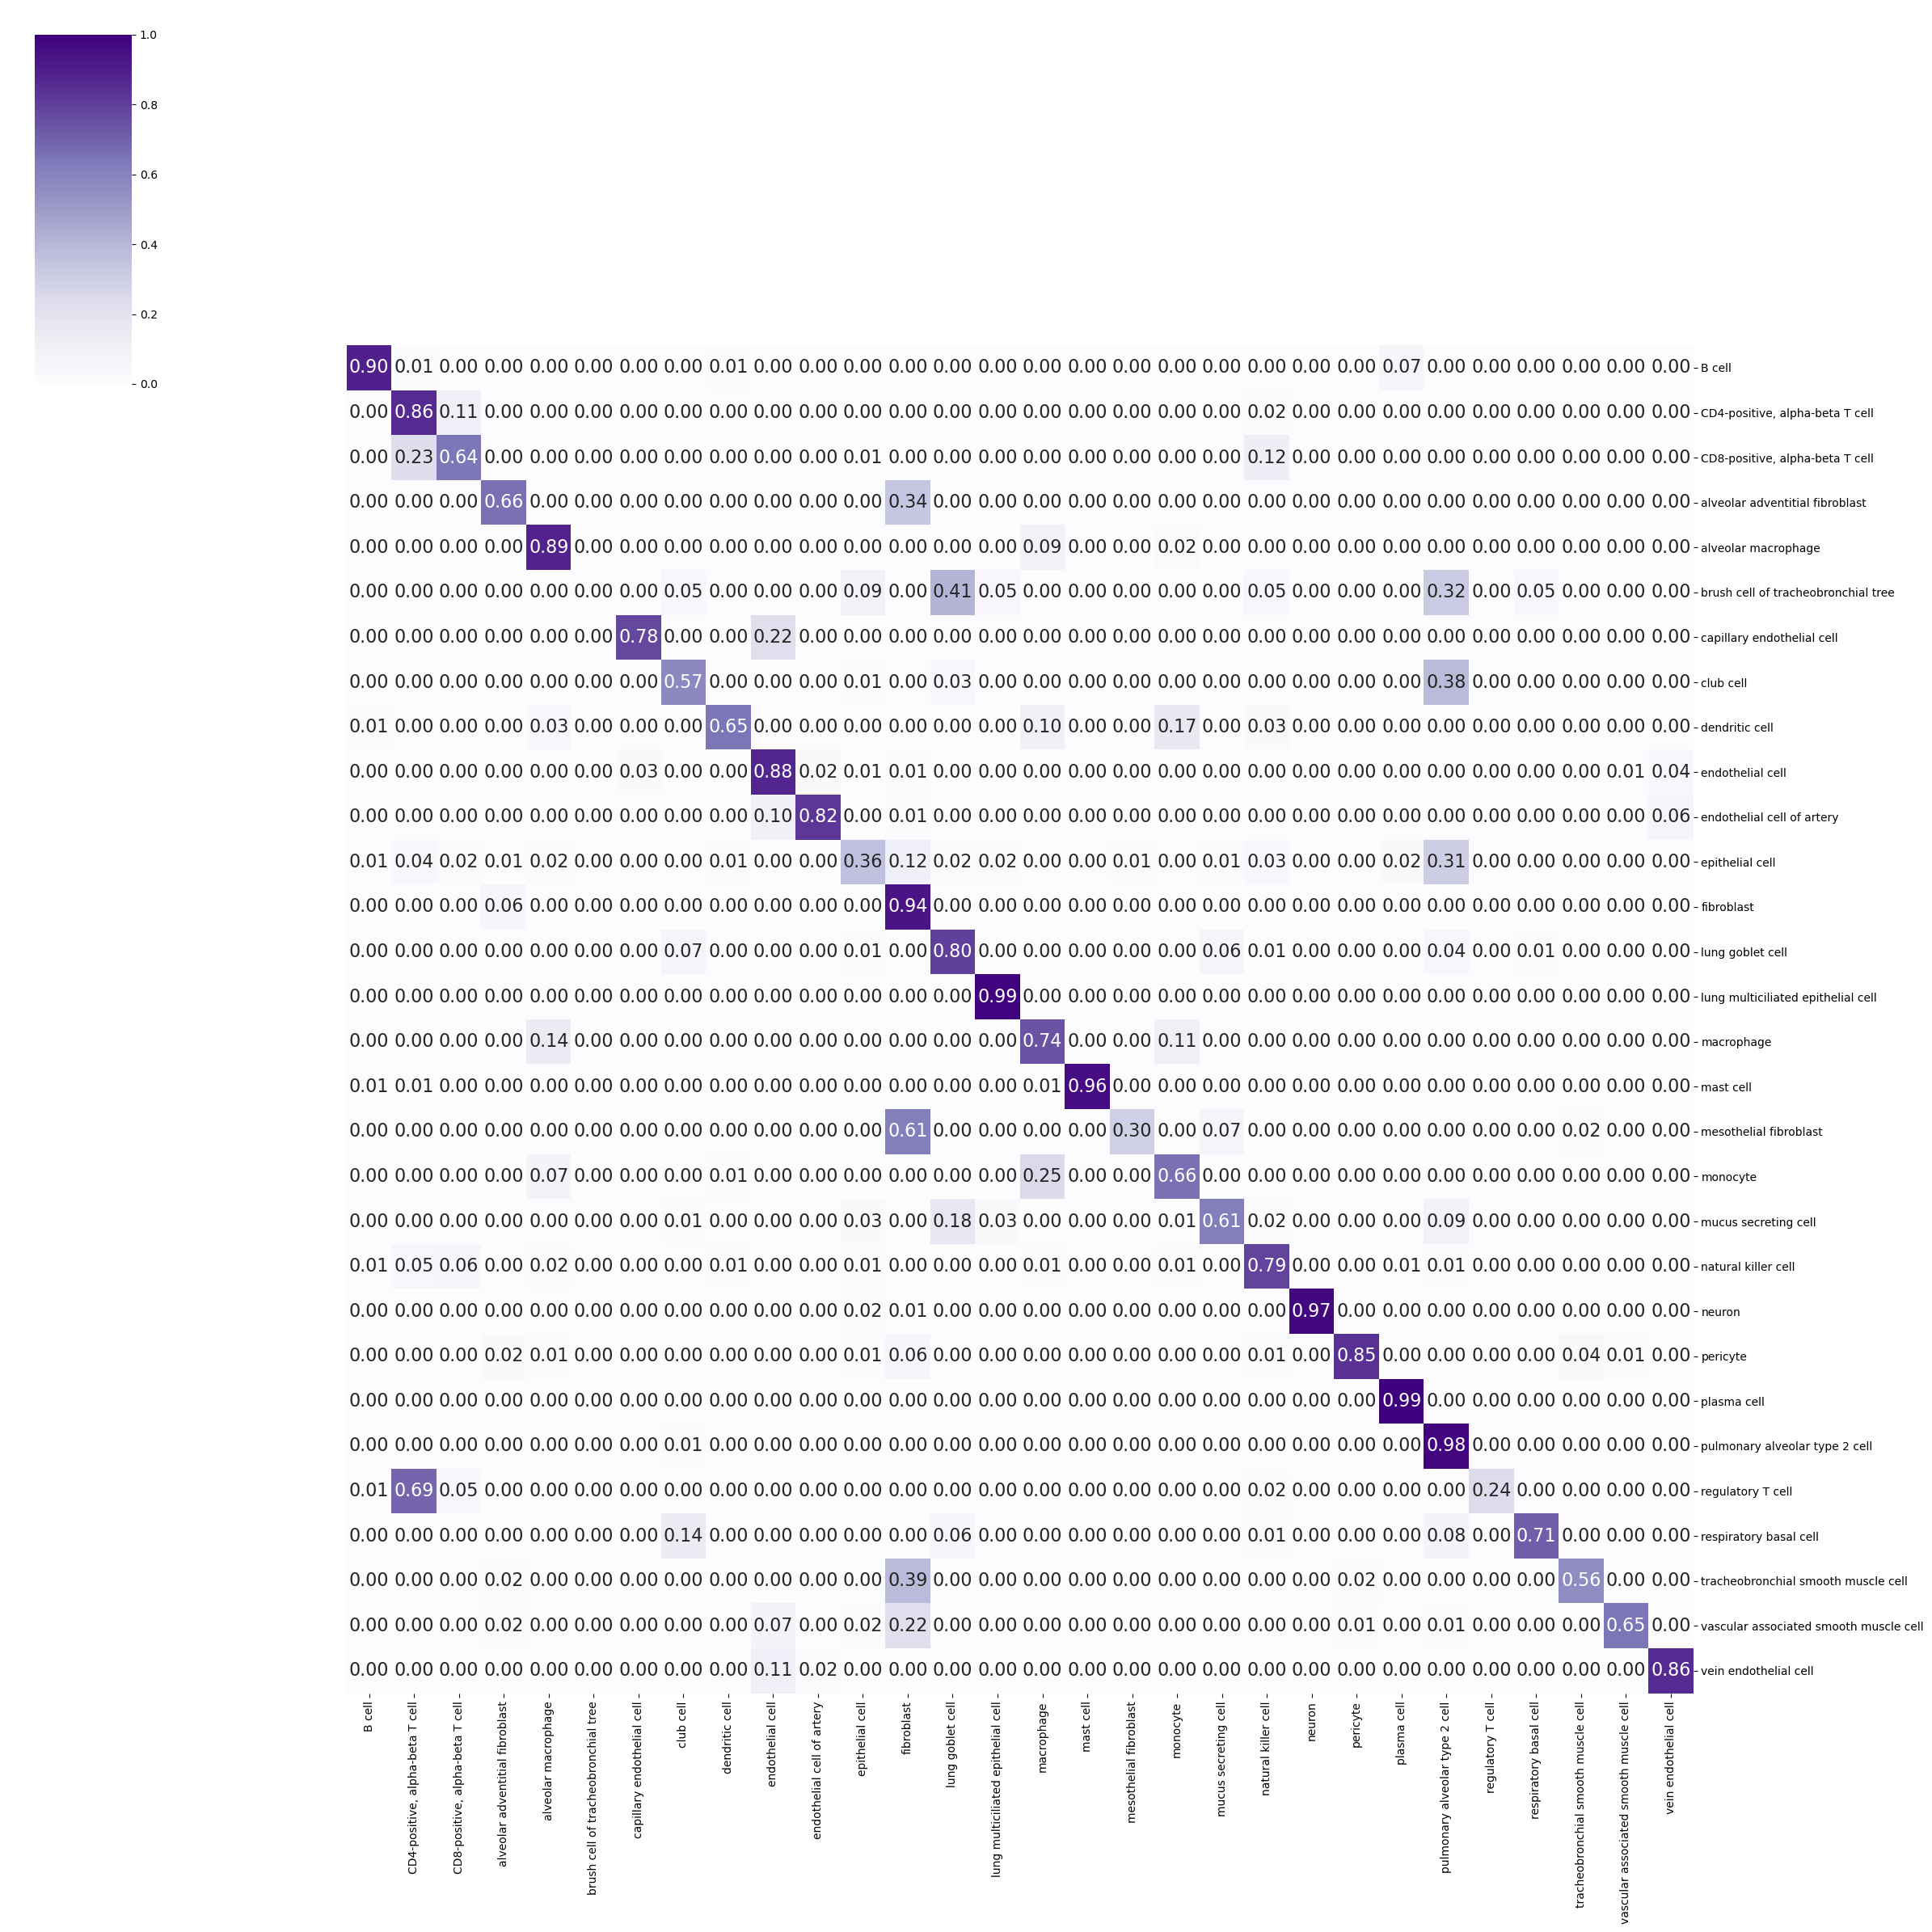

In [14]:
y_true = gt
y_pred = preds
cell_type_list = np.unique(y_true)
matrix = confusion_matrix(y_true, y_pred, labels=cell_type_list)
matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]

df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])

ax = sns.clustermap(df,  
                    cmap='Purples',
                    annot=True ,
                    fmt=".2f", 
                    annot_kws={'size': 16}, 
                    vmin=0, 
                    vmax=1,
                    row_cluster=False, 
                    col_cluster=False, 
                    figsize=(24, 24))